In [1]:
# ----------------------------------------------------------
# Step 0 – Imports and Display Setup
# ----------------------------------------------------------

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import os

# Optional
import warnings
warnings.filterwarnings("ignore")


In [2]:
# ----------------------------------------------------------
# Step 1 – Load Baseline E3SFCA Files
# ----------------------------------------------------------

# Define base path to E3SFCA folder
e3sfca_dir = os.path.join(
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed",
    "E3SFCA"
)

# Load GeoDataFrame with baseline scores
gdf_lsoa = gpd.read_file(os.path.join(e3sfca_dir, "lsoa_e3sfca_accessibility_2024.gpkg"))

# Load CT site list
df_sites_ct = pd.read_csv(os.path.join(e3sfca_dir, "ct_sites_capability.csv"))

# Load filtered travel matrix (car)
df_travel_car = pd.read_csv(os.path.join(e3sfca_dir, "lsoa_to_ct_travel_matrix_car.csv"))

# Confirm shapes
print(f"LSOA: {gdf_lsoa.shape} | CT Sites: {df_sites_ct.shape} | Travel Matrix: {df_travel_car.shape}")


LSOA: (3451, 8) | CT Sites: (36, 23) | Travel Matrix: (19765, 11)


In [3]:
# ----------------------------------------------------------
# Step 2 – Identify Priority Underserved LSOAs (High Demand + Low Access)
# ----------------------------------------------------------

# 1. Define thresholds for "low access" and "high demand"
score_threshold = gdf_lsoa["e3sfca_score_car"].quantile(0.2)   # bottom 20%
demand_threshold = gdf_lsoa["ct_total_demand"].median()        # above-median demand

# 2. Apply filters
gdf_lsoa["low_access"] = gdf_lsoa["e3sfca_score_car"] <= score_threshold
gdf_lsoa["high_demand"] = gdf_lsoa["ct_total_demand"] >= demand_threshold

# 3. Tag LSOAs that meet both criteria
gdf_lsoa["priority_underserved"] = gdf_lsoa["low_access"] & gdf_lsoa["high_demand"]

# 4. Create filtered GeoDataFrame
gdf_priority = gdf_lsoa[gdf_lsoa["priority_underserved"]].copy()

# 5. Output check
print(f"Priority underserved LSOAs identified: {gdf_priority.shape[0]} of {gdf_lsoa.shape[0]}")


Priority underserved LSOAs identified: 448 of 3451


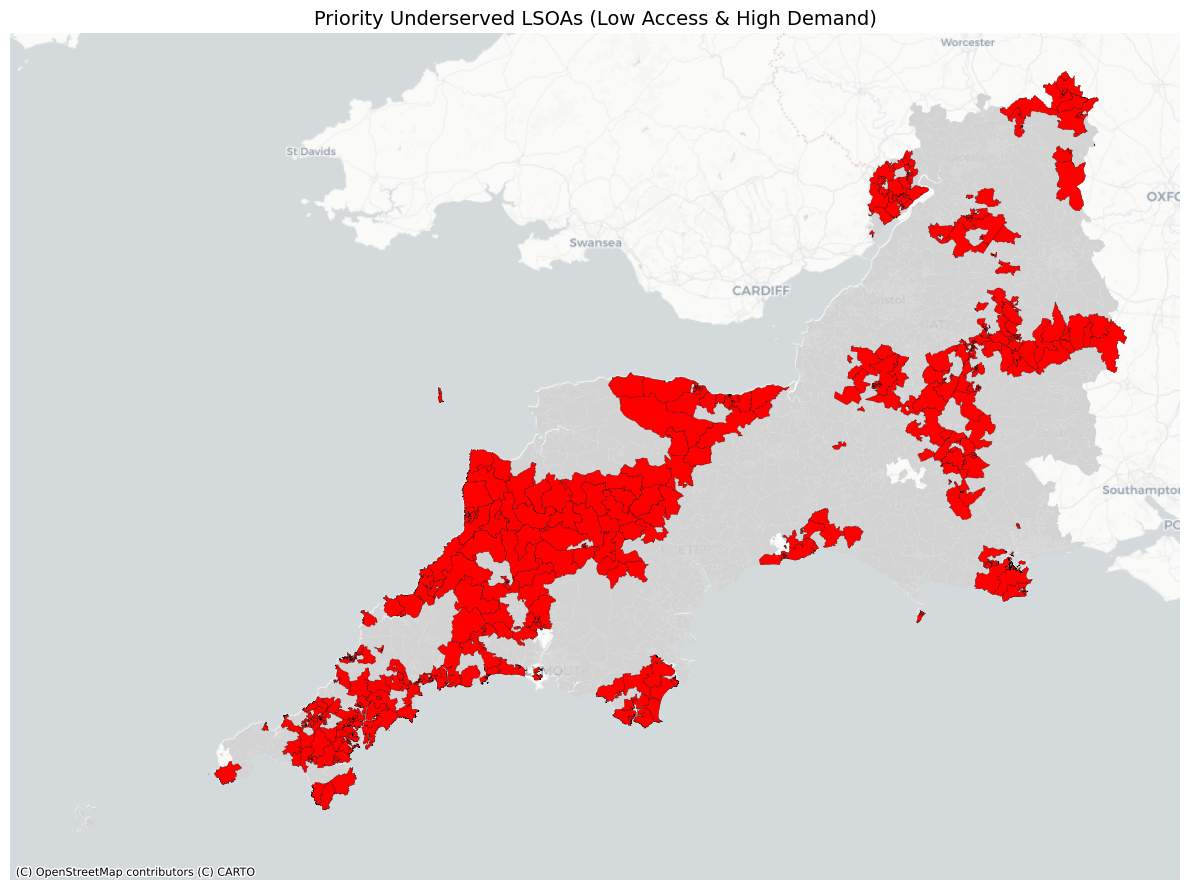

In [4]:
# ----------------------------------------------------------
# Step 2a – Visualise Priority Underserved LSOAs
# ----------------------------------------------------------

# Reproject for plotting
gdf_lsoa_plot = gdf_lsoa.to_crs(epsg=3857)

# Split into priority and non-priority groups
gdf_priority_plot = gdf_lsoa_plot[gdf_lsoa_plot["priority_underserved"] == True]
gdf_nonpriority_plot = gdf_lsoa_plot[gdf_lsoa_plot["priority_underserved"] == False]

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

# Non-priority LSOAs in light grey
gdf_nonpriority_plot.plot(ax=ax, color="lightgrey", edgecolor="none")

# Priority underserved LSOAs in red
gdf_priority_plot.plot(ax=ax, color="red", edgecolor="black", linewidth=0.2)

# Basemap
ctx.add_basemap(ax, crs=gdf_lsoa_plot.crs, source=ctx.providers.CartoDB.Positron)

# Formatting
ax.set_title("Priority Underserved LSOAs (Low Access & High Demand)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


In [5]:
# ----------------------------------------------------------
# Step 3 – Cluster and Rank Underserved LSOAs to Propose New Sites
# ----------------------------------------------------------

from sklearn.cluster import KMeans

# 1. Calculate centroids of underserved LSOAs
gdf_priority["centroid"] = gdf_priority.geometry.centroid
gdf_priority["x"] = gdf_priority["centroid"].x
gdf_priority["y"] = gdf_priority["centroid"].y

# 2. Define number of proposed new sites (clusters)
n_clusters = 4  # Adjust as needed
coords = gdf_priority[["x", "y"]].values

# 3. Apply KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
gdf_priority["cluster"] = kmeans.fit_predict(coords)

# 4. Summarise each cluster: total demand, average access, count
cluster_stats = (
    gdf_priority
    .groupby("cluster")
    .agg(
        total_demand=("ct_total_demand", "sum"),
        avg_access_score=("e3sfca_score_car", "mean"),
        lsoa_count=("lsoa21cd", "count"),
        x_mean=("x", "mean"),
        y_mean=("y", "mean")
    )
    .reset_index()
)

# 5. Rank clusters by highest demand and lowest access (composite)
cluster_stats["rank_score"] = (
    cluster_stats["total_demand"].rank(ascending=False) +
    cluster_stats["avg_access_score"].rank(ascending=True)
)
cluster_stats["rank"] = cluster_stats["rank_score"].rank(method="dense").astype(int)

# 6. Prepare GeoDataFrame of proposed sites
cluster_stats["Site Name"] = cluster_stats["rank"].apply(lambda r: f"Scenario Site {r}")
cluster_stats["CT Scanners"] = 1
cluster_stats["Type"] = "Scenario"

gdf_new_sites = gpd.GeoDataFrame(
    cluster_stats,
    geometry=gpd.points_from_xy(cluster_stats["x_mean"], cluster_stats["y_mean"]),
    crs=gdf_priority.crs
)

# 7. Output check
print(gdf_new_sites[["Site Name", "total_demand", "avg_access_score", "rank"]])


         Site Name  total_demand  avg_access_score  rank
0  Scenario Site 2  32670.706249          0.000030     2
1  Scenario Site 1  31319.653947          0.000021     1
2  Scenario Site 2  29852.360969          0.000023     2
3  Scenario Site 3  15901.432077          0.000025     3


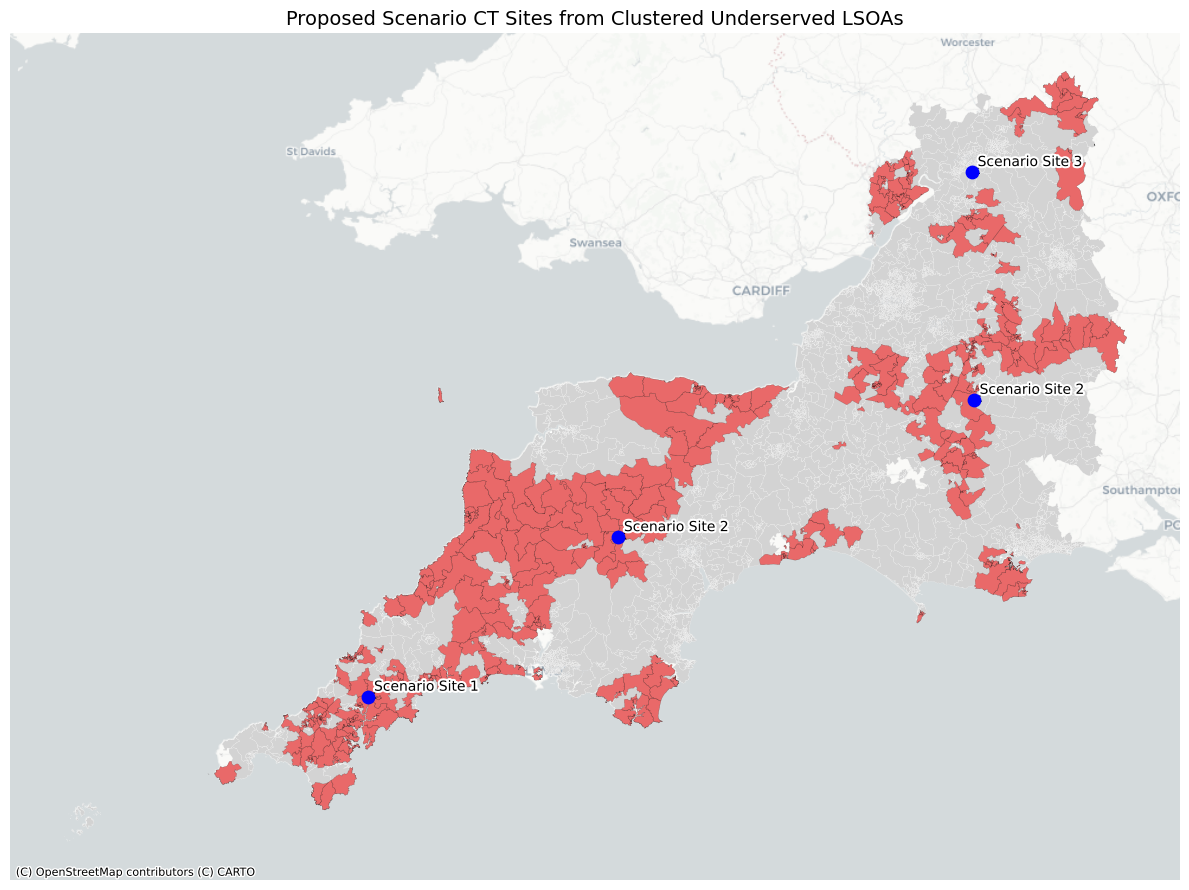

In [6]:
# ----------------------------------------------------------
# Step 3a – Visualise Proposed Scenario Sites with Arrows and Labels
# ----------------------------------------------------------

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# Reproject LSOAs and sites for plotting
gdf_plot = gdf_lsoa.to_crs(epsg=3857)
gdf_new_sites = gdf_new_sites.to_crs(epsg=3857)

# Base plot of all LSOAs in grey
fig, ax = plt.subplots(figsize=(12, 10))
gdf_plot.plot(ax=ax, color="lightgrey", edgecolor="white", linewidth=0.1)

# Plot underserved LSOAs in red
gdf_priority.to_crs(epsg=3857).plot(ax=ax, color="red", alpha=0.5, edgecolor="black", linewidth=0.2)

# Plot proposed sites
gdf_new_sites.plot(ax=ax, color="blue", markersize=80, zorder=5)

# Add arrows and labels for each scenario site
for idx, row in gdf_new_sites.iterrows():
    x, y = row.geometry.x, row.geometry.y
    label = row["Site Name"]

    # Offset for label placement
    dx, dy = 3000, 3000  # adjust as needed based on map scale

    ax.annotate(
        label,
        xy=(x, y),
        xytext=(x + dx, y + dy),
        arrowprops=dict(arrowstyle="->", color="black", lw=1),
        fontsize=10,
        path_effects=[path_effects.withStroke(linewidth=3, foreground="white")]
    )

# Basemap
ctx.add_basemap(ax, crs=gdf_new_sites.crs, source=ctx.providers.CartoDB.Positron)

# Formatting
ax.set_title("Proposed Scenario CT Sites from Clustered Underserved LSOAs", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


In [7]:
# ----------------------------------------------------------
# Step 4 – Append Scenario Sites to CT Site List
# ----------------------------------------------------------

# Ensure both GeoDataFrames use the same CRS before combining
gdf_new_sites = gdf_new_sites.to_crs(df_sites_ct.crs if "crs" in df_sites_ct else "EPSG:4326")

# Standardise column structure for merging
df_new_sites = gdf_new_sites[[
    "Site Name",
    "CT Scanners",
    "Type",
    "geometry"
]].copy()

# Rename for consistency
df_new_sites = df_new_sites.rename(columns={"Site Name": "Name"})

# Ensure original CT sites are in GeoDataFrame format
if not isinstance(df_sites_ct, gpd.GeoDataFrame):
    df_sites_ct = gpd.GeoDataFrame(
        df_sites_ct,
        geometry=gpd.points_from_xy(df_sites_ct["longitude"], df_sites_ct["latitude"]),
        crs="EPSG:4326"
    )

# Subset relevant columns from original CT sites
df_sites_ct_clean = df_sites_ct[["Name", "CT Scanners", "Type", "geometry"]].copy()

# Combine baseline and scenario sites
gdf_sites_combined = pd.concat([df_sites_ct_clean, df_new_sites], ignore_index=True)

# Confirm new shape and print counts
print(f"Original CT Sites: {df_sites_ct_clean.shape[0]}")
print(f"Scenario Sites Added: {df_new_sites.shape[0]}")
print(f"Combined Total Sites: {gdf_sites_combined.shape[0]}")


Original CT Sites: 36
Scenario Sites Added: 4
Combined Total Sites: 40


In [19]:
# ----------------------------------------------------------
# Step 4a – Fix Scenario Site Naming to Ensure Uniqueness
# ----------------------------------------------------------

# Force unique site names regardless of rank ties
gdf_new_sites = gdf_new_sites.reset_index(drop=True)
gdf_new_sites["Site Name"] = [f"Scenario Site {i+1}" for i in range(len(gdf_new_sites))]

# Add metadata fields if missing
gdf_new_sites["CT Scanners"] = 1
gdf_new_sites["Type"] = "Scenario"

# ----------------------------------------------------------
# Step 4b – Prepare for Combining with Baseline CT Sites
# ----------------------------------------------------------

# Reproject scenario sites to match CT site CRS
gdf_new_sites = gdf_new_sites.to_crs(df_sites_ct.crs if "crs" in df_sites_ct else "EPSG:4326")

# Ensure correct column names and order
df_new_sites = gdf_new_sites[["Site Name", "CT Scanners", "Type", "geometry"]].copy()
df_new_sites = df_new_sites.rename(columns={"Site Name": "Name"})

# Convert baseline CT sites to GeoDataFrame if needed
if not isinstance(df_sites_ct, gpd.GeoDataFrame):
    df_sites_ct = gpd.GeoDataFrame(
        df_sites_ct,
        geometry=gpd.points_from_xy(df_sites_ct["longitude"], df_sites_ct["latitude"]),
        crs="EPSG:4326"
    )

# Subset necessary columns from original CT sites
df_sites_ct_clean = df_sites_ct[["Name", "CT Scanners", "Type", "geometry"]].copy()

# ----------------------------------------------------------
# Step 4c – Combine All CT Sites (Baseline + Scenario)
# ----------------------------------------------------------

gdf_sites_combined = pd.concat([df_sites_ct_clean, df_new_sites], ignore_index=True)

# Output check
print(f"Original CT Sites: {df_sites_ct_clean.shape[0]}")
print(f"Scenario Sites Added: {df_new_sites.shape[0]}")
print(f"Combined Total Sites: {gdf_sites_combined.shape[0]}")


Original CT Sites: 36
Scenario Sites Added: 4
Combined Total Sites: 40


In [58]:
# ----------------------------------------------------------
# Step 5 – Filter Travel Matrix for All CT Sites (Baseline + Scenario)
# ----------------------------------------------------------

# 1. Load full LSOA-to-LSOA travel matrix (car mode)
travel_matrix_path = os.path.join(
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/raw",
    "LSOA_to_LSOA_complete.csv"
)
df_travel_full = pd.read_csv(travel_matrix_path)

# 2. Ensure CRS match between CT sites and LSOA polygons
gdf_sites_combined = gdf_sites_combined.to_crs(gdf_lsoa.crs)

# 3. Spatial join to assign destination LSOA codes to all CT sites
df_joined = gpd.sjoin(
    gdf_sites_combined,
    gdf_lsoa[["lsoa21cd", "geometry"]],
    how="left",
    predicate="intersects"
)

# 4. Auto-detect LSOA code column (handles possible suffixes)
lsoa_col = [col for col in df_joined.columns if "lsoa21cd" in col][0]

# 5. Create lookup table: site name → destination LSOA code
df_site_lsoa_lookup = df_joined[["Name", lsoa_col]].rename(columns={lsoa_col: "destination_lsoa"})
df_site_lsoa_lookup = df_site_lsoa_lookup.dropna(subset=["destination_lsoa"])

# 6. Confirm mapping
print(f"Mapped CT sites to {df_site_lsoa_lookup['destination_lsoa'].nunique()} unique LSOAs")

# 7. Filter travel matrix to retain only destinations that are CT sites
df_travel_filtered = df_travel_full[
    df_travel_full["destination_name"].isin(df_site_lsoa_lookup["destination_lsoa"])
].copy()

# 8. Output checks
print(f"Filtered Travel Matrix: {df_travel_filtered.shape}")
print(f"Number of unique destination LSOAs (CT Sites): {df_travel_filtered['destination_name'].nunique()}")


Mapped CT sites to 34 unique LSOAs
Filtered Travel Matrix: (98338, 5)
Number of unique destination LSOAs (CT Sites): 34


In [60]:
# ----------------------------------------------------------
# Step 6 – Merge Travel Matrix with LSOA Attributes and Scanner Supply (Safe Version)
# ----------------------------------------------------------

# 1. Drop overlapping columns
cols_to_drop = [
    "ct_access_car_lt_20", "ct_access_car_20_40",
    "ct_access_car_gt_40", "e3sfca_score_car"
]
gdf_lsoa_clean = gdf_lsoa.drop(columns=[col for col in cols_to_drop if col in gdf_lsoa.columns])

# 2. Enrich with LSOA-level data
df_travel_enriched = df_travel_filtered.merge(
    gdf_lsoa_clean[["lsoa21cd", "priority_underserved", "total_population", "ct_total_demand"]],
    left_on="origin_name",
    right_on="lsoa21cd",
    how="left"
)

# 3. Build a lookup from CT sites: destination LSOA ↔ site name ↔ CT scanners
# Deduplicate to avoid multi-index errors
df_site_lsoa_unique = df_site_lsoa_lookup.drop_duplicates(subset=["destination_lsoa"])
df_site_scanner = df_site_lsoa_unique.merge(
    gdf_sites_combined[["Name", "CT Scanners"]],
    on="Name",
    how="left"
)

# 4. Merge CT scanner supply directly into travel matrix
df_travel_enriched = df_travel_enriched.merge(
    df_site_scanner[["destination_lsoa", "CT Scanners"]],
    left_on="destination_name",
    right_on="destination_lsoa",
    how="left"
)

# 5. Rename for consistency
df_travel_enriched = df_travel_enriched.rename(columns={"CT Scanners": "ct_scanner_supply"})

# 6. Drop rows with no scanner supply (if any)
df_travel_enriched = df_travel_enriched.dropna(subset=["ct_scanner_supply"])

# 7. Add travel time band flags
df_travel_enriched["lt_20"] = df_travel_enriched["travel_time_car"] < 20
df_travel_enriched["20_40"] = df_travel_enriched["travel_time_car"].between(20, 40, inclusive="left")
df_travel_enriched["gt_40"] = df_travel_enriched["travel_time_car"] > 40

# 8. Output check
print(f"Enriched Travel Matrix Shape: {df_travel_enriched.shape}")
display(df_travel_enriched.head())


Enriched Travel Matrix Shape: (98338, 14)


,origin_name,destination_name,travel_time_car,travel_time_pt_peak,travel_time_pt_nonpeak,lsoa21cd,priority_underserved,total_population,ct_total_demand,destination_lsoa,ct_scanner_supply,lt_20,20_40,gt_40
0,E01022266,E01015569,68.827676,126.167676,122.537676,E01022266,False,1418.53,191.481432,E01015569,1,False,False,True
1,E01022267,E01015569,71.650230,139.380230,139.380230,E01022267,False,1831.68,247.465941,E01015569,1,False,False,True
2,E01014659,E01015569,46.115808,80.075808,80.075808,E01014659,False,2221.42,151.852929,E01015569,1,False,False,True
3,E01029177,E01015569,118.540360,216.730360,211.730360,E01029177,False,1317.79,156.164999,E01015569,1,False,False,True
4,E01029174,E01015569,116.579582,215.699582,210.699582,E01029174,False,1097.99,161.452831,E01015569,1,False,False,True


In [61]:
# ----------------------------------------------------------
# Step 7 – Compute Accessibility Scores by Time Band
# ----------------------------------------------------------

# 1. Group scanner supply per origin and time band
access_lt20 = df_travel_enriched[df_travel_enriched["lt_20"]].groupby("origin_name")["ct_scanner_supply"].sum()
access_20_40 = df_travel_enriched[df_travel_enriched["20_40"]].groupby("origin_name")["ct_scanner_supply"].sum()
access_gt40 = df_travel_enriched[df_travel_enriched["gt_40"]].groupby("origin_name")["ct_scanner_supply"].sum()

# 2. Create an accessibility DataFrame
access_scores = pd.DataFrame(index=df_travel_enriched["origin_name"].unique())
access_scores["ct_access_car_lt_20"] = access_lt20
access_scores["ct_access_car_20_40"] = access_20_40
access_scores["ct_access_car_gt_40"] = access_gt40

# 3. Fill NaNs with 0 (i.e., no scanner access in that band)
access_scores = access_scores.fillna(0)

# 4. Optional: merge back in demand info for future metrics
access_scores = access_scores.merge(
    gdf_lsoa[["lsoa21cd", "ct_total_demand"]],
    left_index=True,
    right_on="lsoa21cd",
    how="left"
)

# 5. Final preview
print("Accessibility Scores Preview:")
display(access_scores.head())


Accessibility Scores Preview:


,ct_access_car_lt_20,ct_access_car_20_40,ct_access_car_gt_40,lsoa21cd,ct_total_demand
1682,0.0,6.0,52.0,E01022266,191.481432
1831,0.0,6.0,52.0,E01022267,247.465941
1460,6.0,3.0,49.0,E01014659,151.852929
3114,0.0,4.0,54.0,E01029177,156.164999
3112,0.0,5.0,53.0,E01029174,161.452831


Index in access_scores: None
LSOA code column in gdf_lsoa: True

Delta Summary:


,ct_access_car_lt_20_delta,ct_access_car_20_40_delta,ct_access_car_gt_40_delta
count,3451.000000,3451.0,3451.0
mean,-0.005216,0.0,0.0
std,0.148330,0.0,0.0
min,-6.000000,0.0,0.0
25%,0.000000,0.0,0.0
50%,0.000000,0.0,0.0
75%,0.000000,0.0,0.0
max,0.000000,0.0,0.0


ct_access_car_lt_20_delta: 6 LSOAs changed
ct_access_car_20_40_delta: 0 LSOAs changed
ct_access_car_gt_40_delta: 0 LSOAs changed


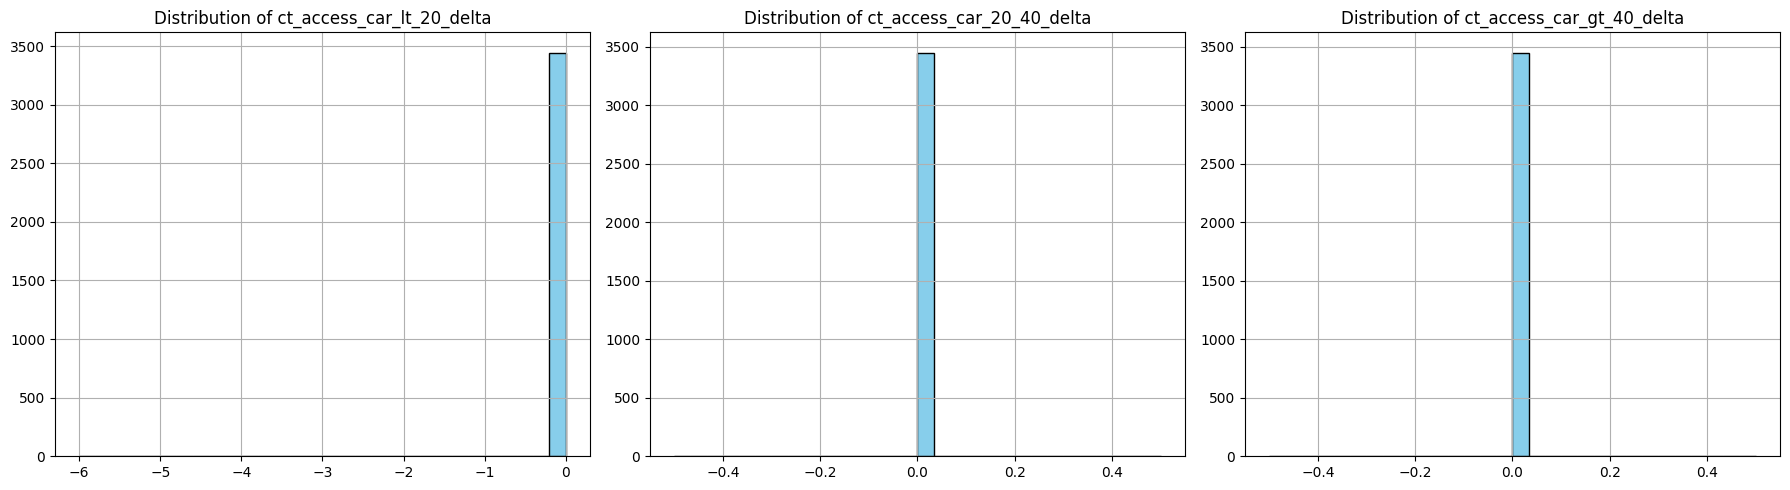

In [62]:
# ----------------------------------------------------------
# Step 7a – Verify Delta Values for Accessibility Change
# ----------------------------------------------------------

# 1. Check that index is consistent between access_scores and gdf_lsoa
print("Index in access_scores:", access_scores.index.name)
print("LSOA code column in gdf_lsoa:", "lsoa21cd" in gdf_lsoa.columns)

# 2. Check delta distribution
delta_cols = [
    "ct_access_car_lt_20_delta",
    "ct_access_car_20_40_delta",
    "ct_access_car_gt_40_delta"
]
print("\nDelta Summary:")
display(gdf_lsoa[delta_cols].describe())

# 3. Count number of LSOAs that had any positive or negative change
for col in delta_cols:
    changed = (gdf_lsoa[col] != 0) & (~gdf_lsoa[col].isna())
    print(f"{col}: {changed.sum()} LSOAs changed")

# 4. Optional: Visualise histogram of change
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(delta_cols):
    gdf_lsoa[col].hist(bins=30, ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()
